In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
import io
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [3]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [4]:
pred_occu = pred['occupancy_recon'].to(torch.device('cpu'))
pred_flow = pred['flow_recon'].to(torch.device('cpu'))
pred_speed = pred['speed_recon'].to(torch.device('cpu'))

pred_k_t = pred['k_t'].to(torch.device('cpu'))

pred_k_x = pred['k_x'].to(torch.device('cpu'))
pred_q_x = pred['q_x'].to(torch.device('cpu'))
pred_v_x = pred['v_x'].to(torch.device('cpu'))
pred_k_t_predict = pred['k_t_predict'].to(torch.device('cpu'))

pred_k_xx = pred['k_xx'].to(torch.device('cpu'))
pred_q_xx = pred['q_xx'].to(torch.device('cpu'))
pred_v_xx = pred['v_xx'].to(torch.device('cpu'))

In [5]:
occupancy_recon = torch.cat((X_occu_all, pred_occu), dim=1).detach().numpy()
flow_recon = torch.cat((X_occu_all, pred_flow), dim=1).detach().numpy()
speed_recon = torch.cat((X_occu_all, pred_speed), dim=1).detach().numpy()

k_t = torch.cat((X_occu_all, pred_k_t), dim=1).detach().numpy()
k_x = torch.cat((X_occu_all,pred_k_x), dim=1).detach().numpy()
q_x = torch.cat((X_occu_all, pred_q_x), dim=1).detach().numpy()
v_x = torch.cat((X_occu_all, pred_v_x), dim=1).detach().numpy()

k_xx = torch.cat((X_occu_all,pred_k_xx), dim=1).detach().numpy()
q_xx = torch.cat((X_occu_all, pred_q_xx), dim=1).detach().numpy()
v_xx = torch.cat((X_occu_all, pred_v_xx), dim=1).detach().numpy()

k_t_predict = torch.cat((X_occu_all, pred_k_t_predict), dim=1).detach().numpy()

occupancy_recon = pd.DataFrame(occupancy_recon, columns = ['TimeStep','Station_Number','Occupancy'])
flow_recon = pd.DataFrame(flow_recon, columns = ['TimeStep','Station_Number','Flow'])
speed_recon = pd.DataFrame(speed_recon, columns = ['TimeStep','Station_Number','Speed'])

k_t = pd.DataFrame(k_t, columns = ['TimeStep','Station_Number','k_t'])

k_x = pd.DataFrame(k_x, columns = ['TimeStep', 'Station_Number', 'k_x'])
q_x = pd.DataFrame(q_x, columns = ['TimeStep', 'Station_Number', 'q_x'])
v_x = pd.DataFrame(v_x, columns = ['TimeStep', 'Station_Number', 'v_x'])

k_xx = pd.DataFrame(k_xx, columns = ['TimeStep', 'Station_Number', 'k_xx'])
q_xx = pd.DataFrame(q_xx, columns = ['TimeStep', 'Station_Number', 'q_xx'])
v_xx = pd.DataFrame(v_xx, columns = ['TimeStep', 'Station_Number', 'v_xx'])

k_t_predict = pd.DataFrame(k_t_predict, columns=['TimeStep', 'Station_Number', 'k_t'])

In [6]:
Flow = pd.read_csv('Data_Clean/Flow_all.csv',index_col='Station_PM')
Occupancy = pd.read_csv('Data_Clean/Occupancy_all.csv',index_col='Station_PM')
Speed = pd.read_csv('Data_Clean/Speed_all.csv',index_col='Station_PM')

In [7]:
Flow_ori = pd.read_csv('Data_Clean/Flow.csv',index_col='Station_PM')
Occupancy_ori = pd.read_csv('Data_Clean/Occupancy.csv',index_col='Station_PM')
Speed_ori = pd.read_csv('Data_Clean/Speed.csv',index_col='Station_PM')

## Plot Reconstructed Data

In [8]:
occupancy_recon['TimeStep'] = occupancy_recon['TimeStep'].astype(int)
occupancy_recon['Station_Number'] = occupancy_recon['Station_Number'].astype(int)
flow_recon['TimeStep'] = flow_recon['TimeStep'].astype(int)
flow_recon['Station_Number'] = flow_recon['Station_Number'].astype(int)
speed_recon['TimeStep'] = speed_recon['TimeStep'].astype(int)
speed_recon['Station_Number'] = speed_recon['Station_Number'].astype(int)

In [9]:
occupancy_recon_wide = occupancy_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
flow_recon_wide = flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Flow')
speed_recon_wide = speed_recon.pivot(index='Station_Number', columns='TimeStep', values='Speed')

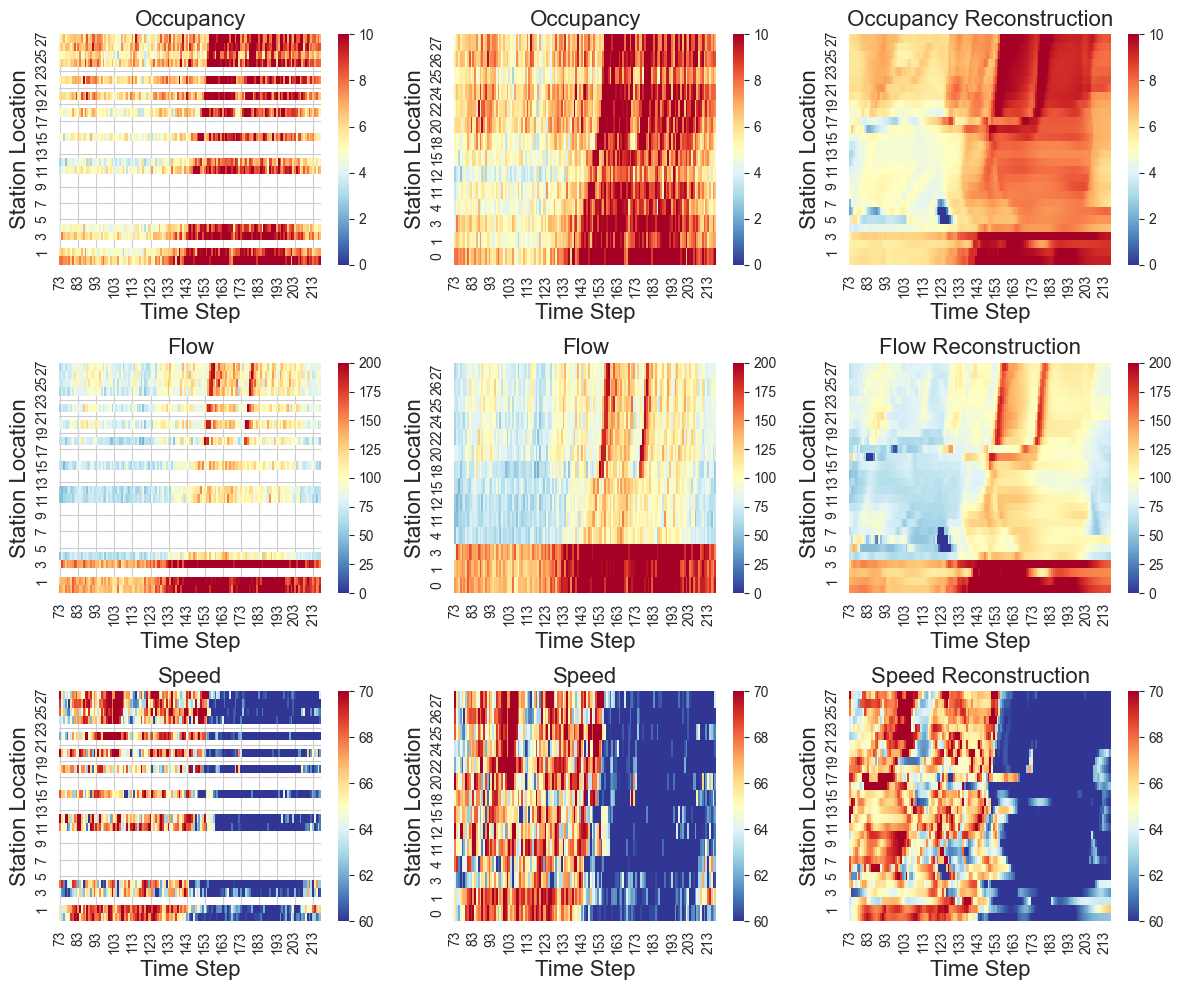

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

vmin1_occu, vmax1_occu = 0, 10

sns.heatmap(100*Occupancy.iloc[:,72:217].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=axs[0,0])
axs[0,0].set_ylabel('Station Location', fontsize = 16)
axs[0,0].set_xlabel('Time Step',  fontsize = 16)
axs[0,0].set_title("Occupancy",  fontsize = 16)

sns.heatmap(100*Occupancy_ori.iloc[:,72:217].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=axs[0,1])
axs[0,1].set_ylabel('Station Location', fontsize = 16)
axs[0,1].set_xlabel('Time Step',  fontsize = 16)
axs[0,1].set_title("Occupancy",  fontsize = 16)


sns.heatmap(occupancy_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=axs[0,2])
axs[0,2].set_ylabel('Station Location',  fontsize = 16)
axs[0,2].set_xlabel('Time Step',  fontsize = 16)
axs[0,2].set_title("Occupancy Reconstruction",  fontsize = 16)

vmin1_flow, vmax1_flow = 0, 200

sns.heatmap(Flow.iloc[:,72:217].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_flow, vmax=vmax1_flow, annot=False, ax=axs[1,0])
axs[1,0].set_ylabel('Station Location',  fontsize = 16)
axs[1,0].set_xlabel('Time Step',  fontsize = 16)
axs[1,0].set_title("Flow",  fontsize = 16)

sns.heatmap(Flow_ori.iloc[:,72:217].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_flow, vmax=vmax1_flow, annot=False, ax=axs[1,1])
axs[1,1].set_ylabel('Station Location',  fontsize = 16)
axs[1,1].set_xlabel('Time Step',  fontsize = 16)
axs[1,1].set_title("Flow",  fontsize = 16)

sns.heatmap(flow_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_flow, vmax=vmax1_flow, annot=False, ax=axs[1,2])
axs[1,2].set_ylabel('Station Location',  fontsize = 16)
axs[1,2].set_xlabel('Time Step',  fontsize = 16)
axs[1,2].set_title("Flow Reconstruction",  fontsize = 16)

vmin1_speed, vmax1_speed = 60, 70

sns.heatmap(Speed.iloc[:,72:217].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_speed, vmax=vmax1_speed, annot=False, ax=axs[2,0])
axs[2,0].set_ylabel('Station Location',  fontsize = 16)
axs[2,0].set_xlabel('Time Step',  fontsize = 16)
axs[2,0].set_title("Speed",  fontsize = 16)

sns.heatmap(Speed_ori.iloc[:,72:217].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_speed, vmax=vmax1_speed, annot=False, ax=axs[2,1])
axs[2,1].set_ylabel('Station Location',  fontsize = 16)
axs[2,1].set_xlabel('Time Step',  fontsize = 16)
axs[2,1].set_title("Speed",  fontsize = 16)

sns.heatmap(speed_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_speed, vmax=vmax1_speed, annot=False, ax=axs[2,2])
axs[2,2].set_ylabel('Station Location',  fontsize = 16)
axs[2,2].set_xlabel('Time Step',  fontsize = 16)
axs[2,2].set_title("Speed Reconstruction",  fontsize = 16)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures_linear/Heatmap_all.png", dpi = 300)

In [11]:
k_t['TimeStep'] = k_t['TimeStep'].astype(int)
k_t['Station_Number'] = k_t['Station_Number'].astype(int)

k_t_predict['TimeStep'] = k_t_predict['TimeStep'].astype(int)
k_t_predict['Station_Number'] = k_t_predict['Station_Number'].astype(int)

k_x['TimeStep'] = k_x['TimeStep'].astype(int)
k_x['Station_Number'] = k_x['Station_Number'].astype(int)

q_x['TimeStep'] = q_x['TimeStep'].astype(int)
q_x['Station_Number'] = q_x['Station_Number'].astype(int)

v_x['TimeStep'] = v_x['TimeStep'].astype(int)
v_x['Station_Number'] = v_x['Station_Number'].astype(int)

In [12]:
k_t_wide = k_t.pivot(index='Station_Number', columns='TimeStep', values='k_t')
k_t_predict_wide = k_t_predict.pivot(index='Station_Number', columns='TimeStep', values='k_t')

k_x_wide = k_x.pivot(index='Station_Number', columns='TimeStep', values='k_x')

q_x_wide = q_x.pivot(index='Station_Number', columns='TimeStep', values='q_x')

v_x_wide = v_x.pivot(index='Station_Number', columns='TimeStep', values='v_x')

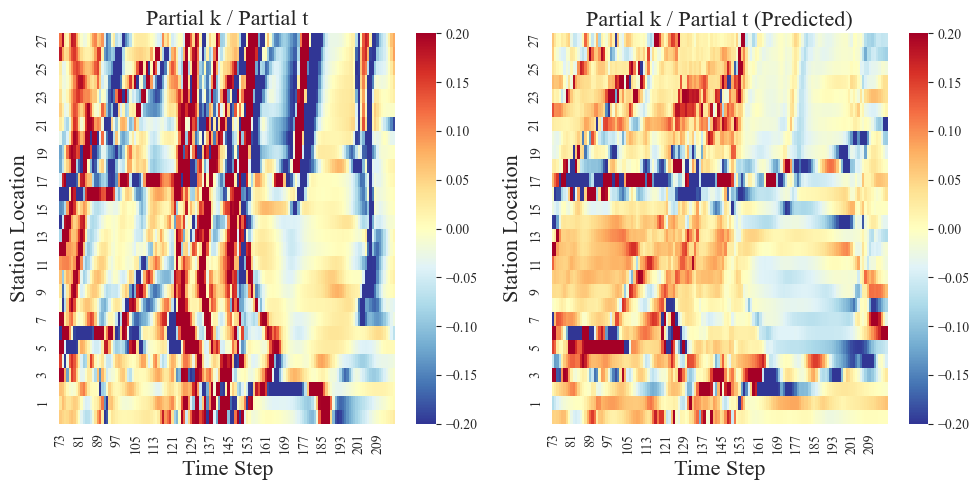

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

vmin, vmax = -0.2, 0.2
sns.heatmap(k_t_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin, vmax=vmax, annot=False, robust=True, ax=axs[0])
axs[0].set_ylabel('Station Location',  fontsize = 16)
axs[0].set_xlabel('Time Step',  fontsize = 16)
axs[0].set_title("Partial k / Partial t",  fontsize = 16)

sns.heatmap(k_t_predict_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin, vmax=vmax, annot=False,robust=True, ax=axs[1])
axs[1].set_ylabel('Station Location',  fontsize = 16)
axs[1].set_xlabel('Time Step',  fontsize = 16)
axs[1].set_title("Partial k / Partial t (Predicted)",  fontsize = 16)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures_linear/k_dev.png", dpi = 300)

In [14]:
k_xx['TimeStep'] = k_xx['TimeStep'].astype(int)
k_xx['Station_Number'] = k_xx['Station_Number'].astype(int)

q_xx['TimeStep'] = q_xx['TimeStep'].astype(int)
q_xx['Station_Number'] = q_xx['Station_Number'].astype(int)

v_xx['TimeStep'] = v_xx['TimeStep'].astype(int)
v_xx['Station_Number'] = v_xx['Station_Number'].astype(int)

In [15]:
k_xx_wide = k_xx.pivot(index='Station_Number', columns='TimeStep', values='k_xx')

q_xx_wide = q_xx.pivot(index='Station_Number', columns='TimeStep', values='q_xx')

v_xx_wide = v_xx.pivot(index='Station_Number', columns='TimeStep', values='v_xx')

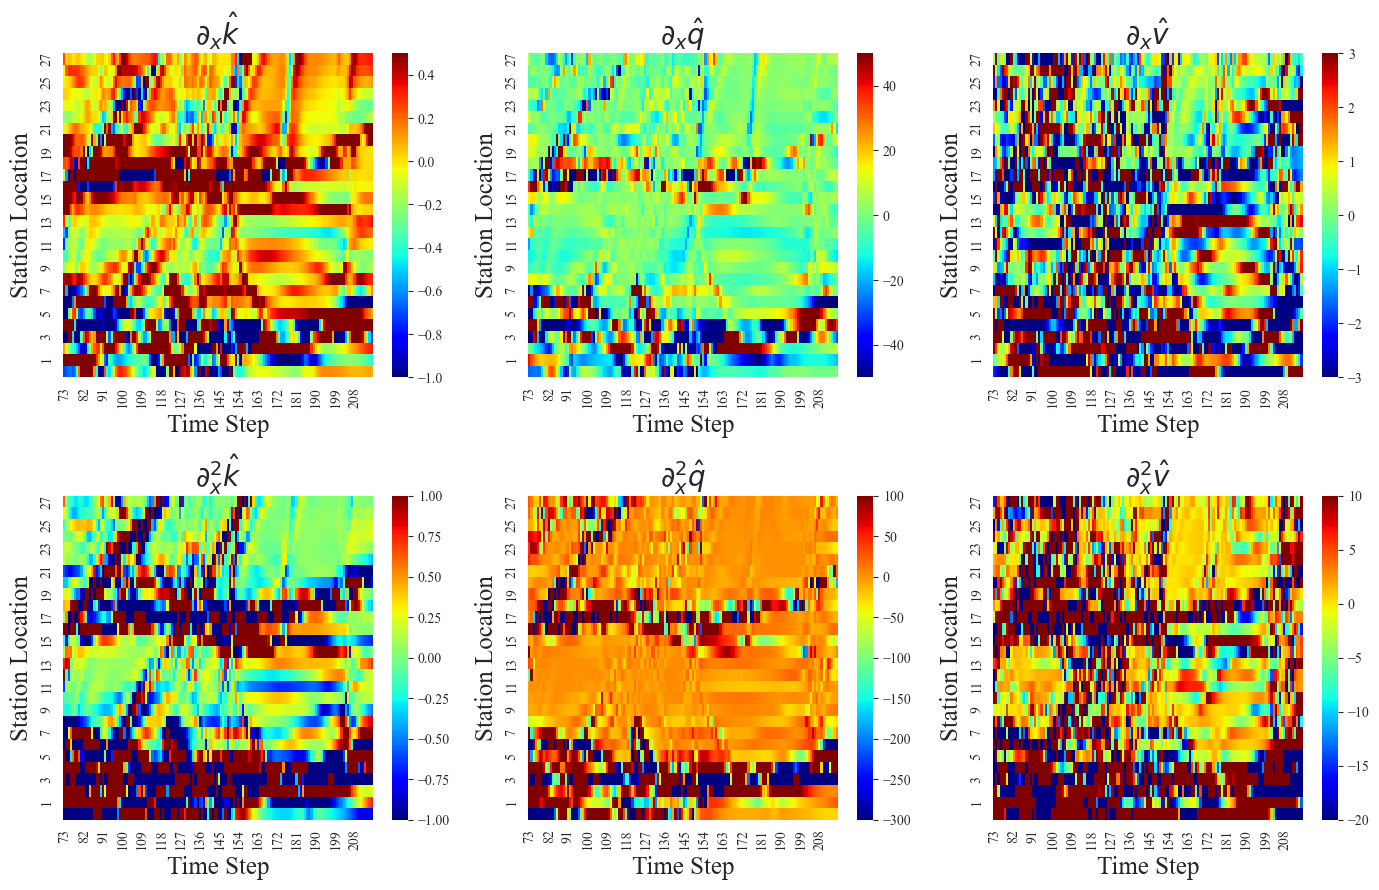

In [18]:
# partial derivatives

fig, axs = plt.subplots(2, 3, figsize=(14, 9))

sns.heatmap(k_x_wide.iloc[::-1], cmap="jet",vmin=-1, vmax=0.5, annot=False,robust=True, ax=axs[0,0])
axs[0,0].set_ylabel('Station Location',  fontsize = 18)
axs[0,0].set_xlabel('Time Step',  fontsize = 18)
axs[0,0].set_title(r'$\partial_x \hat{k}$',  fontsize = 20)

sns.heatmap(q_x_wide.iloc[::-1], cmap="jet", vmin=-50, vmax=50, annot=False,robust=True, ax=axs[0,1])
axs[0,1].set_ylabel('Station Location',  fontsize = 18)
axs[0,1].set_xlabel('Time Step',  fontsize = 18)
axs[0,1].set_title(r'$\partial_x \hat{q}$',  fontsize = 20)

sns.heatmap(v_x_wide.iloc[::-1], cmap="jet", vmin=-3, vmax=3, annot=False,robust=True, ax=axs[0,2])
axs[0,2].set_ylabel('Station Location',  fontsize = 18)
axs[0,2].set_xlabel('Time Step',  fontsize = 18)
axs[0,2].set_title(r'$\partial_x \hat{v}$',  fontsize = 20)


sns.heatmap(k_xx_wide.iloc[::-1], cmap="jet", vmin=-1, vmax=1, annot=False,robust=True, ax=axs[1,0])
axs[1,0].set_ylabel('Station Location',  fontsize = 18)
axs[1,0].set_xlabel('Time Step',  fontsize = 18)
axs[1,0].set_title(r'$\partial_x^2 \hat{k}$',  fontsize = 20)

sns.heatmap(q_xx_wide.iloc[::-1], cmap="jet", vmin=-300, vmax=100, annot=False,robust=True, ax=axs[1,1])
axs[1,1].set_ylabel('Station Location',  fontsize = 18)
axs[1,1].set_xlabel('Time Step',  fontsize = 18)
axs[1,1].set_title(r'$\partial_x^2 \hat{q}$',  fontsize = 20)

sns.heatmap(v_xx_wide.iloc[::-1], cmap="jet", vmin=-20, vmax=10, annot=False,robust=True, ax=axs[1,2])
axs[1,2].set_ylabel('Station Location',  fontsize = 18)
axs[1,2].set_xlabel('Time Step',  fontsize = 18)
axs[1,2].set_title(r'$\partial_x^2 \hat{v}$',  fontsize = 20)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures_linear/all_derivatives.png", dpi = 300)

In [19]:
pred['coefficients'].T

tensor([[-3.3741e-01,  0.0000e+00,  0.0000e+00,  5.8678e-03, -2.4315e-01,
          5.0372e-03, -1.2374e-04,  1.0509e-03, -0.0000e+00, -0.0000e+00]])

In [20]:
coeff = pd.DataFrame(pred['coefficients'].T)

In [21]:
coeff.to_csv('Coeffs_linear/coefficients.csv', index=False)